In [1]:
%pip install pandas seaborn matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import sqlite3

# Créer une base test temporaire pour vérifier SQLite
test_conn = sqlite3.connect("../sql/test.db")
cursor = test_conn.cursor()
cursor.execute("CREATE TABLE IF NOT EXISTS test_table(id INTEGER)")
test_conn.commit()
test_conn.close()

print("SQLite fonctionne parfaitement !")

SQLite fonctionne parfaitement !


In [3]:
import sqlite3
import pandas as pd

# Connexion principale pour le projet
conn = sqlite3.connect("../sql/python_sql_movie_analysis.db")  # ou juste "python_sql_movie_analysis.db"

# Charger les CSV dans des DataFrames
users = pd.read_csv("../data/u.user", sep="|", names=["user_id","age","gender","occupation","zip_code"])
movies = pd.read_csv("../data/u.item", sep="|", names=["movie_id","title","release_date","video_release_date","imdb_url",
                                                       "unknown","Action","Adventure","Animation","Children","Comedy","Crime",
                                                       "Documentary","Drama","Fantasy","Film-Noir","Horror","Musical","Mystery",
                                                       "Romance","Sci-Fi","Thriller","War","Western"], encoding="latin-1")
ratings = pd.read_csv("../data/u.data", sep="\t", names=["user_id","movie_id","rating","timestamp"])

# Assurer que release_date est bien au format datetime
movies['release_date'] = pd.to_datetime(movies['release_date'], format='%d-%b-%Y', errors='coerce')

# Vérifier les premières lignes pour s'assurer que les dates sont bien converties
movies[['title', 'release_date']].head()


# Charger les tables dans SQLite
users.to_sql("users", conn, if_exists="replace", index=False)
movies.to_sql("movies", conn, if_exists="replace", index=False)
ratings.to_sql("ratings", conn, if_exists="replace", index=False)

print("Tables importées avec succès !")

Tables importées avec succès !


In [4]:
# Top 5 films les mieux notés

query = """
SELECT m.title, AVG(r.rating) as avg_rating, COUNT(r.rating) as n_ratings
FROM ratings r
JOIN movies m ON r.movie_id = m.movie_id
GROUP BY m.title
HAVING COUNT(r.rating) >= 20
ORDER BY avg_rating DESC
LIMIT 5;
"""
top_movies = pd.read_sql(query, conn)
print(top_movies)

                                               title  avg_rating  n_ratings
0                              Close Shave, A (1995)    4.491071        112
1                            Schindler's List (1993)    4.466443        298
2                         Wrong Trousers, The (1993)    4.466102        118
3                                  Casablanca (1942)    4.456790        243
4  Wallace & Gromit: The Best of Aardman Animatio...    4.447761         67


In [5]:
# Utilisateurs les plus actifs

query = """
SELECT user_id, COUNT(*) as n_ratings
FROM ratings
GROUP BY user_id
ORDER BY n_ratings DESC
LIMIT 5;
"""
top_users = pd.read_sql(query, conn)
print(top_users)


   user_id  n_ratings
0      405        737
1      655        685
2       13        636
3      450        540
4      276        518


In [6]:
# Distribution des notes par valeurs

query = "SELECT rating, COUNT(*) as n FROM ratings GROUP BY rating ORDER BY rating"
rating_dist = pd.read_sql(query, conn)
print(rating_dist)

   rating      n
0       1   6110
1       2  11370
2       3  27145
3       4  34174
4       5  21201


In [7]:
# Top 5 des genres les plus populaires

query = """
SELECT 
    SUM(Action) as Action,
    SUM(Adventure) as Adventure,
    SUM(Animation) as Animation,
    SUM(Children) as Children,
    SUM(Comedy) as Comedy,
    SUM(Crime) as Crime,
    SUM(Documentary) as Documentary,
    SUM(Drama) as Drama,
    SUM(Fantasy) as Fantasy,
    SUM(`Film-Noir`) as FilmNoir,
    SUM(Horror) as Horror,
    SUM(Musical) as Musical,
    SUM(Mystery) as Mystery,
    SUM(Romance) as Romance,
    SUM(`Sci-Fi`) as SciFi,
    SUM(Thriller) as Thriller,
    SUM(War) as War,
    SUM(Western) as Western
FROM movies
"""
genre_counts = pd.read_sql(query, conn)
print(genre_counts.T.sort_values(by=0, ascending=False).head(5))


            0
Drama     725
Comedy    505
Thriller  251
Action    251
Romance   247


In [8]:
# Top 5 des films les plus noté

query = """
SELECT m.title, COUNT(r.rating) as n_ratings
FROM ratings r
JOIN movies m ON r.movie_id = m.movie_id
GROUP BY m.title
ORDER BY n_ratings DESC
LIMIT 5;
"""
most_rated_movies = pd.read_sql(query, conn)
print(most_rated_movies)


                       title  n_ratings
0           Star Wars (1977)        583
1             Contact (1997)        509
2               Fargo (1996)        508
3  Return of the Jedi (1983)        507
4           Liar Liar (1997)        485


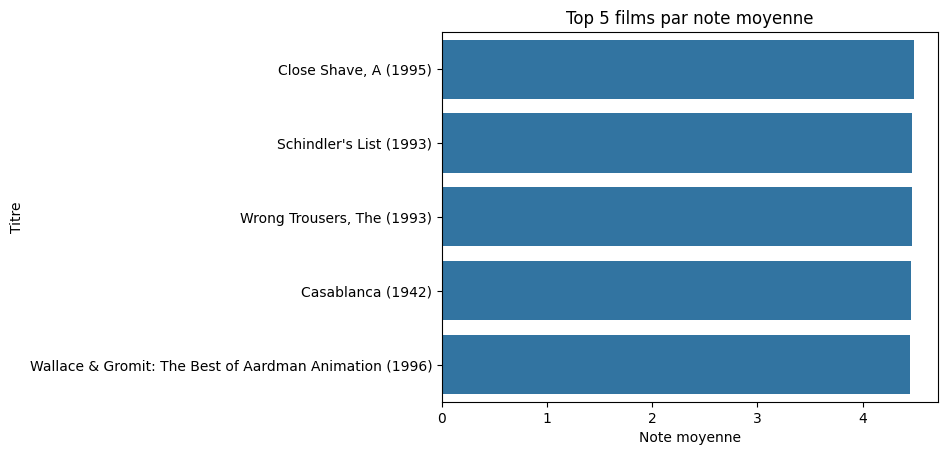

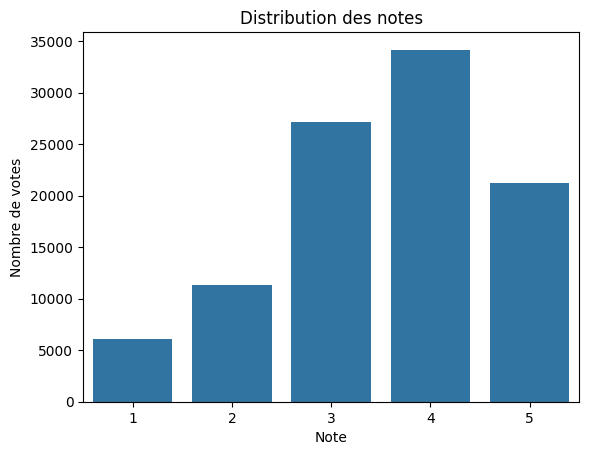

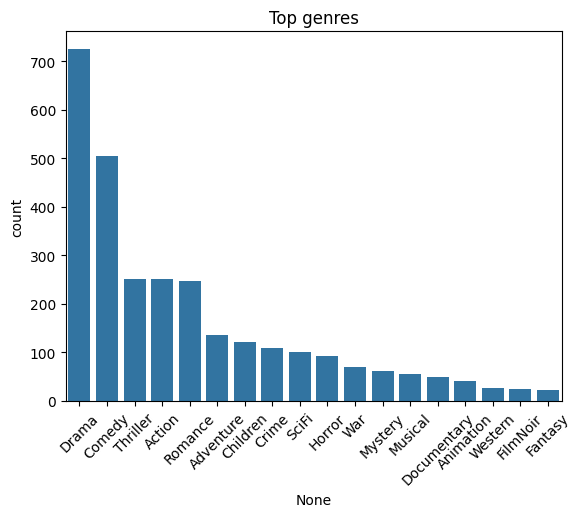

In [9]:
# Visualisation avec Python / Seaborn

import matplotlib.pyplot as plt
import seaborn as sns

# Top films par note moyenne
sns.barplot(x="avg_rating", y="title", data=top_movies)
plt.title("Top 5 films par note moyenne")
plt.xlabel("Note moyenne")
plt.ylabel("Titre")
plt.show()

# Distribution des notes
sns.barplot(x="rating", y="n", data=rating_dist)
plt.title("Distribution des notes")
plt.xlabel("Note")
plt.ylabel("Nombre de votes")
plt.show()

# Top genres
genre_counts_t = genre_counts.T
genre_counts_t.columns = ["count"]
genre_counts_t = genre_counts_t.sort_values(by="count", ascending=False)
sns.barplot(x=genre_counts_t.index, y="count", data=genre_counts_t)
plt.title("Top genres")
plt.xticks(rotation=45)
plt.show()


In [10]:
# Calculer l'année de sortie si ce n'est pas déjà fait
movies['year'] = movies['release_date'].dt.year

# Calculer l'âge du film par rapport à l'année actuelle
from datetime import datetime
current_year = datetime.now().year
movies['age'] = current_year - movies['year']

# Vérifier les valeurs manquantes
print("Valeurs manquantes par colonne :")
print(movies.isna().sum())

Valeurs manquantes par colonne :
movie_id                 0
title                    0
release_date             1
video_release_date    1682
imdb_url                 3
unknown                  0
Action                   0
Adventure                0
Animation                0
Children                 0
Comedy                   0
Crime                    0
Documentary              0
Drama                    0
Fantasy                  0
Film-Noir                0
Horror                   0
Musical                  0
Mystery                  0
Romance                  0
Sci-Fi                   0
Thriller                 0
War                      0
Western                  0
year                     1
age                      1
dtype: int64


In [11]:
# Liste des genres
genre_cols = ["Action","Adventure","Animation","Children","Comedy","Crime","Documentary",
              "Drama","Fantasy","Film-Noir","Horror","Musical","Mystery","Romance",
              "Sci-Fi","Thriller","War","Western"]

# Convertir release_date en datetime
movies['release_date'] = pd.to_datetime(movies['release_date'], format='%d-%b-%Y', errors='coerce')

# Créer year et age
from datetime import datetime
current_year = datetime.now().year
movies['year'] = movies['release_date'].dt.year
movies['age'] = current_year - movies['year']

# Vérifier
print(movies[['title','release_date','year','age']].head())

# Fusion des notes et des genres
genre_ratings = ratings.merge(movies[["movie_id"] + genre_cols + ['year','age']], on="movie_id")

# Moyenne des notes par genre
avg_by_genre = {}
for genre in genre_cols:
    # on ne prend que les films de ce genre
    avg_by_genre[genre] = (genre_ratings[genre] * genre_ratings['rating']).sum() / genre_ratings[genre].sum()

# Convertir en DataFrame pour visualisation
avg_genre_df = pd.DataFrame.from_dict(avg_by_genre, orient='index', columns=['avg_rating']).sort_values(by='avg_rating', ascending=False)
print("Moyenne des notes par genre :")
print(avg_genre_df)

# Moyenne des notes par âge du film (groupé par tranche de 5 ans)
age_bins = [0,5,10,20,30,50,100]
genre_ratings['age_group'] = pd.cut(genre_ratings['age'], bins=age_bins)
avg_by_age = genre_ratings.groupby('age_group')['rating'].mean()
print("\nMoyenne des notes par tranche d'âge du film :")
print(avg_by_age)

# Corrélation nombre de votes vs note moyenne par film
votes_per_movie = ratings.groupby('movie_id').count()['rating']
avg_rating_per_movie = ratings.groupby('movie_id').mean()['rating']
corr = votes_per_movie.corr(avg_rating_per_movie)
print(f"\nCorrélation nombre de votes vs note moyenne : {corr:.2f}")

               title release_date    year   age
0   Toy Story (1995)   1995-01-01  1995.0  31.0
1   GoldenEye (1995)   1995-01-01  1995.0  31.0
2  Four Rooms (1995)   1995-01-01  1995.0  31.0
3  Get Shorty (1995)   1995-01-01  1995.0  31.0
4     Copycat (1995)   1995-01-01  1995.0  31.0
Moyenne des notes par genre :
             avg_rating
Film-Noir      3.921523
War            3.815812
Drama          3.687379
Documentary    3.672823
Mystery        3.638132
Crime          3.632278
Romance        3.621705
Western        3.613269
Animation      3.576699
Sci-Fi         3.560723
Musical        3.521397
Thriller       3.509007
Adventure      3.503527
Action         3.480245
Comedy         3.394073
Children       3.353244
Horror         3.290389
Fantasy        3.215237

Moyenne des notes par tranche d'âge du film :
age_group
(0, 5]            NaN
(5, 10]           NaN
(10, 20]          NaN
(20, 30]     3.347658
(30, 50]     3.551866
(50, 100]    3.928562
Name: rating, dtype: float64

Corréla

C:\Users\julie\AppData\Local\Temp\ipykernel_2764\822001463.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_by_age = genre_ratings.groupby('age_group')['rating'].mean()


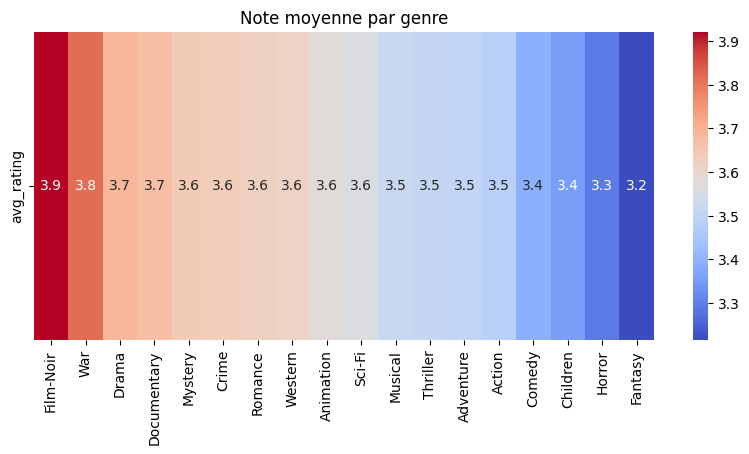

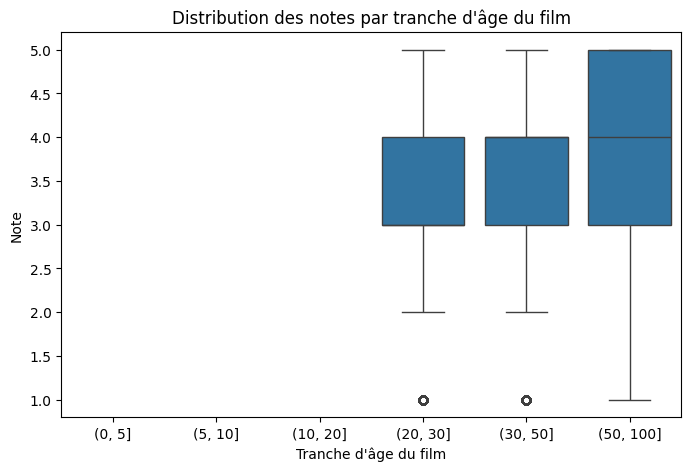

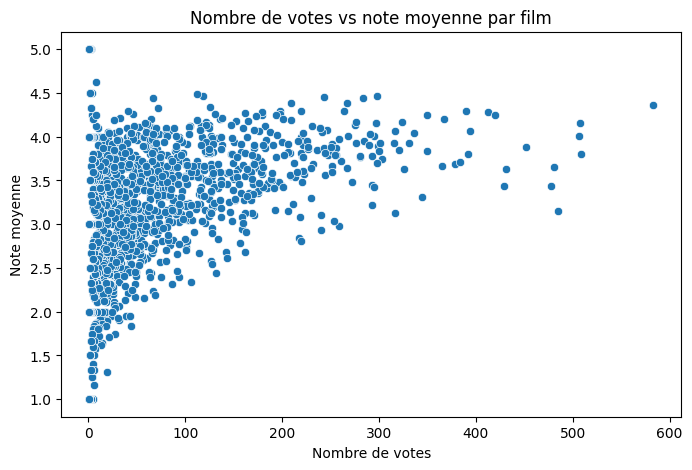

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Heatmap des notes moyennes par genre
plt.figure(figsize=(10,4))
sns.heatmap(avg_genre_df.T, annot=True, cmap="coolwarm", cbar=True)
plt.title("Note moyenne par genre")
plt.show()

# Boxplot de la distribution des notes par tranche d'âge du film
plt.figure(figsize=(8,5))
sns.boxplot(x='age_group', y='rating', data=genre_ratings)
plt.title("Distribution des notes par tranche d'âge du film")
plt.xlabel("Tranche d'âge du film")
plt.ylabel("Note")
plt.show()

# Scatter plot nombre de votes vs note moyenne par film
plt.figure(figsize=(8,5))
sns.scatterplot(x=votes_per_movie, y=avg_rating_per_movie)
plt.title("Nombre de votes vs note moyenne par film")
plt.xlabel("Nombre de votes")
plt.ylabel("Note moyenne")
plt.show()

In [14]:
#Mini prédiction simple (Linear Regression)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
import numpy as np

# Features et target
X = genre_ratings[genre_cols + ['age']].copy()
y = genre_ratings['rating']

# Remplacer NaN par la moyenne de la colonne
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Séparer train/test
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Modèle
model = LinearRegression()
model.fit(X_train, y_train)

# Score
score = model.score(X_test, y_test)
print(f"R² sur le jeu test : {score:.2f}")


R² sur le jeu test : 0.05
